### Import and Setup


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import joblib
import sqlite3
import os

# Set seeds for reproducibility (Industry Standard)
torch.manual_seed(42)
np.random.seed(42)

print(f"✅ PyTorch Version: {torch.__version__}")
print(f"✅ GPU Available: {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

✅ PyTorch Version: 2.9.1+cu128
✅ GPU Available: False


### Data Loading

In [2]:
db_path = '../data/database.db'

def load_data_from_sql(db_path):
    if not os.path.exists(db_path):
        raise FileNotFoundError(f"Database not found at {db_path}. Run src/etl.py first.")
    
    conn = sqlite3.connect(db_path)
    # Load everything. We will filter in memory for this scale.
    df = pd.read_sql("SELECT * FROM sensor_logs", conn)
    conn.close()
    return df

df = load_data_from_sql(db_path)
print(f"📦 Loaded Data Shape: {df.shape}")

📦 Loaded Data Shape: (220320, 53)


### Pre-Porcessing and Data Selection

In [4]:
#STRATEGY 1: "Golden Batch" Training
# We train ONLY on 'NORMAL' data. If we train on 'BROKEN' data, the model 
# learns to think being broken is normal. We want it to fail on broken data.

df_normal = df[df['machine_status'] == 'NORMAL']
print(f"📉 Training Data (Normal Only): {df_normal.shape}")

# STRATEGY 2: Feature Selection
# Drop non-sensor columns and the known broken sensor (sensor_15)
drop_cols = ['timestamp', 'machine_status', 'sensor_15', 'Unnamed: 0']
# Also drop sensor_00 if your EDA showed it's the target label (vibration), 
# but usually we keep it as an input feature for autoencoders.

# Handle columns that might not exist safely
existing_drop = [c for c in drop_cols if c in df_normal.columns]
train_data = df_normal.drop(columns=existing_drop)

# Drop columns with 0 variance (Ghost Sensors)
# In production, you would save this list of dropped columns to apply during inference.
train_data = train_data.loc[:, train_data.var() > 0.0]

# Fill NaNs - Forward fill is best for sensor lag
train_data = train_data.fillna(method='ffill').fillna(method='bfill')

print(f"✨ Final Feature Count: {train_data.shape[1]}")
feature_cols = train_data.columns.tolist()

# Save the list of features so the dashboard knows what to expect
joblib.dump(feature_cols, '../models/feature_columns.joblib')

📉 Training Data (Normal Only): (205836, 53)


/tmp/ipykernel_303031/1901061917.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_data = train_data.fillna(method='ffill').fillna(method='bfill')


✨ Final Feature Count: 51


['../models/feature_columns.joblib']

### Scaling and Splitting Data

In [5]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(train_data)

# Split into Train and Validation
# We don't need a "Test" set with labels here, because we are doing unsupervised training.
X_train, X_val = train_test_split(X_scaled, test_size=0.2, random_state=42)

# Save the Scaler! The dashboard needs this to process live data.
os.makedirs('../models', exist_ok=True)
joblib.dump(scaler, '../models/scaler.joblib')
print("✅ Scaler and Feature list saved to 'models/'")

# Convert to PyTorch Tensors
train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train).float()), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.from_numpy(X_val).float()), batch_size=64, shuffle=False)

✅ Scaler and Feature list saved to 'models/'


### Model Architecture

In [6]:
class IndustrialAutoencoder(nn.Module):
    def __init__(self, input_dim):
        super(IndustrialAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            
            nn.Linear(16, 8) # Bottleneck (Latent Space)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            
            nn.Linear(16, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            
            nn.Linear(32, input_dim),
            nn.Sigmoid() # Sigmoid because data is scaled 0-1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

input_dim = X_train.shape[1]
model = IndustrialAutoencoder(input_dim).to(device)
print(model)

IndustrialAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=51, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Linear(in_features=16, out_features=8, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=51, bias=True)
    (7): Sigmoid()
  )
)


### Training Loop

In [7]:
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

num_epochs = 50
history = {'train_loss': [], 'val_loss': []}
best_val_loss = float('inf')
patience_counter = 0
patience_limit = 10 # Stop if no improvement for 10 epochs

print("🚀 Starting Training...")

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    train_loss = 0
    for batch in train_loader:
        inputs = batch[0].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    
    # Validation Phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs = batch[0].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            val_loss += loss.item()
            
    avg_val_loss = val_loss / len(val_loader)
    
    # Scheduling
    scheduler.step(avg_val_loss)
    
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} | LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Early Stopping Logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), '../models/best_model.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience_limit:
            print("🛑 Early stopping triggered.")
            break

print("✅ Training Complete.")

🚀 Starting Training...
Epoch [1/50] Train Loss: 0.005737 | Val Loss: 0.002266 | LR: 0.001000
Epoch [2/50] Train Loss: 0.002506 | Val Loss: 0.001767 | LR: 0.001000
Epoch [3/50] Train Loss: 0.002198 | Val Loss: 0.001589 | LR: 0.001000
Epoch [4/50] Train Loss: 0.002080 | Val Loss: 0.001531 | LR: 0.001000
Epoch [5/50] Train Loss: 0.002020 | Val Loss: 0.001519 | LR: 0.001000
Epoch [6/50] Train Loss: 0.001967 | Val Loss: 0.001456 | LR: 0.001000
Epoch [7/50] Train Loss: 0.001916 | Val Loss: 0.001437 | LR: 0.001000
Epoch [8/50] Train Loss: 0.001879 | Val Loss: 0.001401 | LR: 0.001000
Epoch [9/50] Train Loss: 0.001867 | Val Loss: 0.001389 | LR: 0.001000
Epoch [10/50] Train Loss: 0.001828 | Val Loss: 0.001362 | LR: 0.001000
Epoch [11/50] Train Loss: 0.001799 | Val Loss: 0.001356 | LR: 0.001000
Epoch [12/50] Train Loss: 0.001783 | Val Loss: 0.001336 | LR: 0.001000
Epoch [13/50] Train Loss: 0.001753 | Val Loss: 0.001283 | LR: 0.001000
Epoch [14/50] Train Loss: 0.001749 | Val Loss: 0.001305 | LR: 0

### Visualization

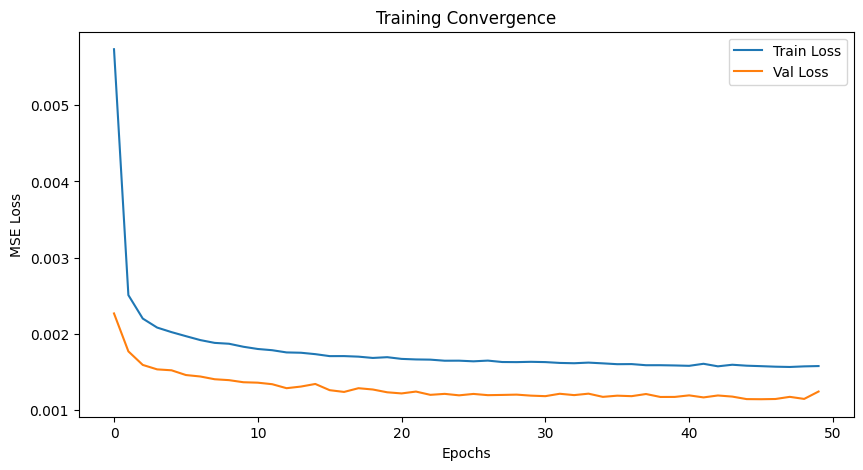

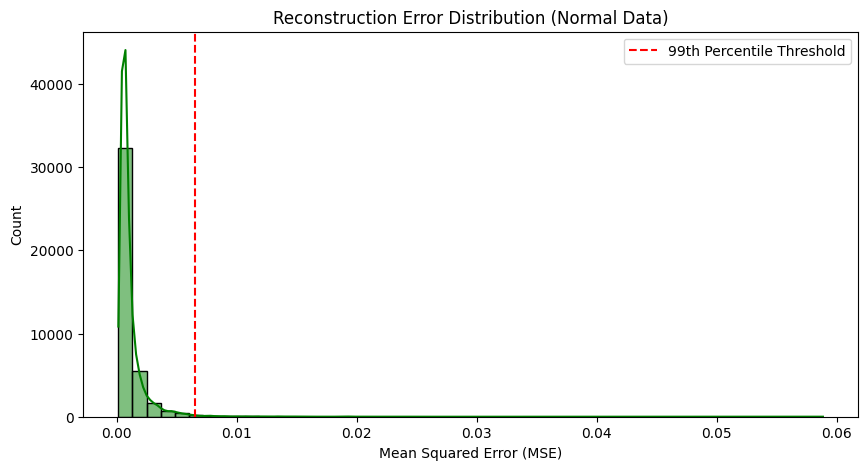

ℹ️ Recommended Threshold (99th Percentile): 0.0065


In [8]:
# Visualization to determine the Anomaly Threshold.
# We plot the reconstruction error of the NORMAL data. 
# Anything significantly higher than this distribution is an anomaly.

plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Training Convergence')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

# Load best model for inference check
model.load_state_dict(torch.load('../models/best_model.pth'))
model.eval()

# Calculate reconstruction error on Validation set
val_tensor = torch.from_numpy(X_val).float().to(device)
with torch.no_grad():
    reconstructions = model(val_tensor)
    loss_per_item = torch.mean((val_tensor - reconstructions) ** 2, dim=1).cpu().numpy()

# Plot Histogram of Normal Errors
plt.figure(figsize=(10, 5))
sns.histplot(loss_per_item, bins=50, kde=True, color='green')
plt.title("Reconstruction Error Distribution (Normal Data)")
plt.xlabel("Mean Squared Error (MSE)")
plt.axvline(np.percentile(loss_per_item, 99), color='red', linestyle='--', label='99th Percentile Threshold')
plt.legend()
plt.show()

print(f"ℹ️ Recommended Threshold (99th Percentile): {np.percentile(loss_per_item, 99):.4f}")

### Tetsing Metrices


🔍 Evaluating on Test Set (Normal Validation + Actual Failures)...

📉 Reconstruction R² Score (Normal Data): 0.7628

📊 Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

      Normal       1.00      0.99      1.00     41168
     Anomaly       0.01      0.71      0.02         7

    accuracy                           0.99     41175
   macro avg       0.51      0.85      0.51     41175
weighted avg       1.00      0.99      1.00     41175



/tmp/ipykernel_303031/1479205338.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_broken_filled = df_broken.fillna(method='ffill').fillna(method='bfill')


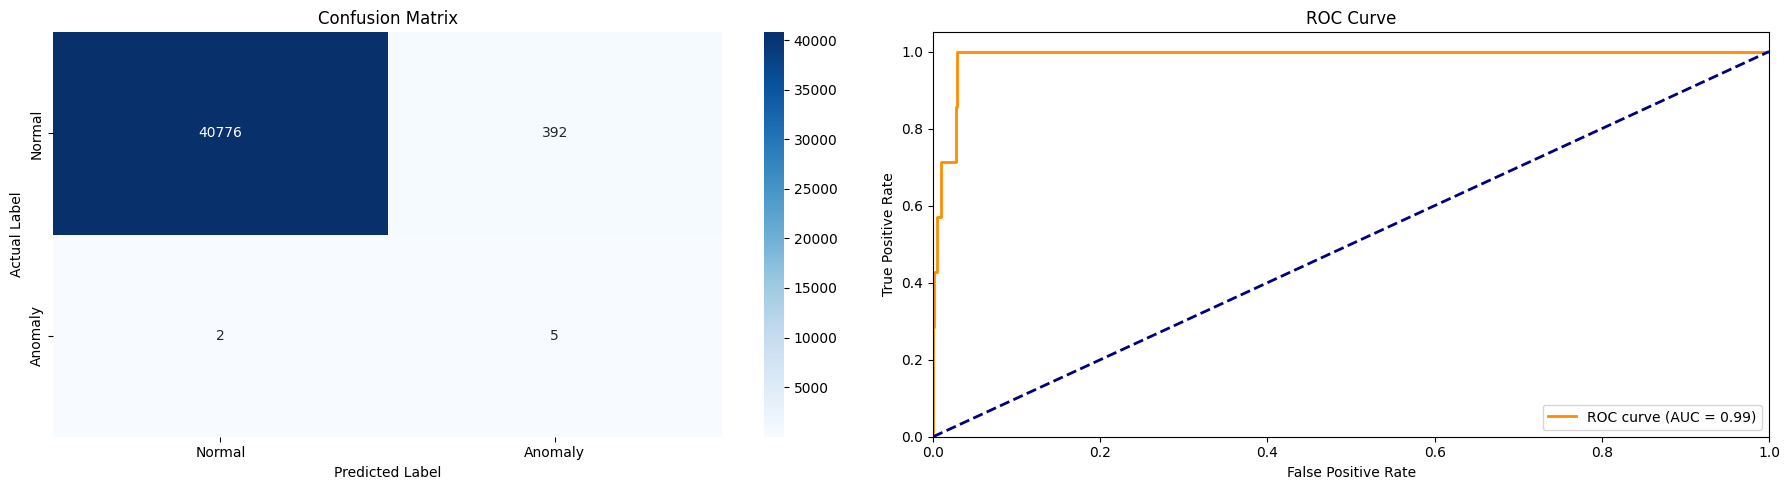

In [31]:
threshold_99 = np.round(np.percentile(loss_per_item, 99.05), 6)
from sklearn.metrics import (confusion_matrix, classification_report, roc_curve, 
                             auc, r2_score, precision_recall_curve)

print("\n🔍 Evaluating on Test Set (Normal Validation + Actual Failures)...")

# 1. Prepare Anomalous Data (The 'BROKEN' rows we excluded earlier)
df_broken = df[df['machine_status'] == 'BROKEN'].copy()

# Ensure we use exactly the same features as training
# Fill missing to ensure robustness
df_broken_filled = df_broken.fillna(method='ffill').fillna(method='bfill')

# Select only the features used in training (handle if any are missing by filling 0)
for col in feature_cols:
    if col not in df_broken_filled.columns:
        df_broken_filled[col] = 0
        
X_broken_features = df_broken_filled[feature_cols]

# Scale using the trained scaler
X_broken_scaled = scaler.transform(X_broken_features)

# 2. Construct Test Set
# X_val contains "Normal" data (Label 0)
# X_broken_scaled contains "Anomaly" data (Label 1)
X_test = np.concatenate([X_val, X_broken_scaled])
y_test = np.concatenate([np.zeros(len(X_val)), np.ones(len(X_broken_scaled))])

# 3. Run Inference
test_tensor = torch.from_numpy(X_test).float().to(device)
with torch.no_grad():
    reconstructions = model(test_tensor)
    # Calculate MSE Loss per sample
    loss = torch.mean((test_tensor - reconstructions) ** 2, dim=1).cpu().numpy()

# --- METRIC 1: Coefficient of Determination (R2) ---
# We calculate this on the Normal data only (X_val) to check reconstruction quality.
# A high R2 on normal data means the model learned the "Normal" pattern well.
X_val_tensor = torch.from_numpy(X_val).float().to(device)
with torch.no_grad():
    rec_val = model(X_val_tensor).cpu().numpy()
r2_normal = r2_score(X_val, rec_val)
print(f"\n📉 Reconstruction R² Score (Normal Data): {r2_normal:.4f}")

# 4. Predict using the calculated Threshold
y_pred = (loss > threshold_99).astype(int)

# 5. Print Classification Report
print("\n📊 Classification Report:")
print("-" * 60)
print(classification_report(y_test, y_pred, target_names=['Normal', 'Anomaly']))

# --- PLOTS: Confusion Matrix, ROC, Precision-Recall ---
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Plot 1: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Anomaly'], 
            yticklabels=['Normal', 'Anomaly'], ax=axes[0])
axes[0].set_title("Confusion Matrix")
axes[0].set_ylabel('Actual Label')
axes[0].set_xlabel('Predicted Label')

# Plot 2: ROC Curve
fpr, tpr, _ = roc_curve(y_test, loss)
roc_auc = auc(fpr, tpr)

axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend(loc="lower right")


plt.tight_layout()
plt.show()

# %%